In [92]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input

from lime import lime_image

In [93]:
import h5py as hd
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/patches_fix.hdf5', 'r', libver='latest', swmr=True)
filename = "../input/pannukeall/all_tumor_pannuke.hdf5"
f = pannuke

f['pannuke/fold2/676/tumor'].keys()
im = f['pannuke/fold2/676/tumor/center/patch'][0]
mask = f['pannuke/fold2/676/tumor/center/mask'][0]

In [94]:
f['pannuke/fold2/676/tumor'].keys()
im = f['pannuke/fold2/676/tumor/center/patch'][0]
mask = f['pannuke/fold2/676/tumor/center/mask'][0]

In [95]:
model = tf.keras.models.load_model('/mnt/nas2/results/IntermediateResults/Mara/MELBA/baseline_def_1/best_model.h5', compile=False)
model.layers[-1].activation = tf.keras.activations.sigmoid
model.compile()

In [96]:
#We don't directly use the base model because we want to be sure we are perturbing the images before preprocessing them.
#Otherwise covering the superpixels in 0 might not mean covering them in black.
#Best way to control this is to just define a wrapper-like class around the model, that includes the preprocessing in it.
#I'm also converting the sigmoid output to softmax-like because that's generally easier to handle and debug in LIME.
#GradCAM doesn't care about any of this so we can just use the model directly.

class MyModel():
    def __init__(self,model):
        self.model = model
        self.input_shape = model.input_shape
        self.output_shape = model.output_shape
        
    def predict(self, batch_images):
        
        #Image must be preprocessed before passed to LIME.
        batch_images = preprocess_input(batch_images.copy()) 
        
        sigm = self.model.predict(batch_images)
        
        softm = np.hstack((1-sigm,sigm))
        
        return softm


model_with_preprocessing = MyModel(model)

In [97]:
#Renumber segments, because they are numbered arbitrarily in the mask files.
segments = mask[:,:,0].copy()
for i, num in enumerate(np.unique(mask[:,:,0])):
    
    segments[segments==num]=i

#LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
def segfunc(im):
    return segments

In [98]:
#Generate Squares
from skimage.segmentation import mark_boundaries
squares = np.zeros(im.shape[:2])
counter = 0
for hor in range(3):
    for ver in range(3):
        squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
        counter+=1

#Renumber segments, because they are numbered arbitrarily in the mask files.
segments = np.sum(mask[:,:,0:5],axis=2).copy()

temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

renumbering_map = dict(zip(np.unique(segments),temp_renumber))

segments = np.vectorize(renumbering_map.get)(segments)
segments = np.where(segments.copy()==8,squares,segments)

#LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
def segfunc(im):
    return segments

#Mark the nuclei
mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
mark = im.copy()/255

(-0.5, 223.5, 223.5, -0.5)

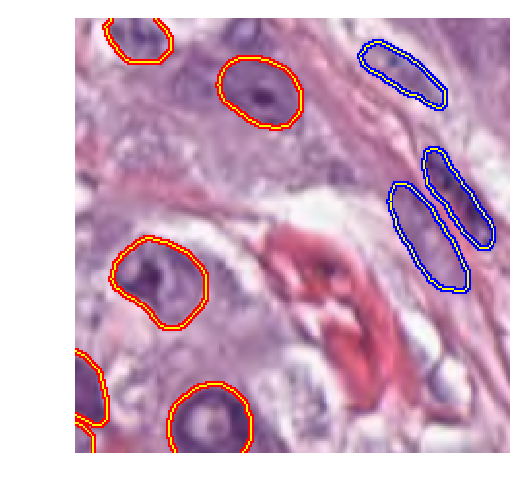

In [99]:
for i in range(5):
    mark = mark_boundaries(mark,mask[:,:,i].astype('uint8'),mode='outer',outline_color=mark_colors[i])
plt.imshow(mark)
plt.axis("off")

In [64]:
dim=(1,2,3)

In [67]:
len(dim)

3

In [66]:
np.random.randn(dim[0],dim[1],dim[2])

array([[[-0.10308904, -0.30402183,  1.38019864],
        [-1.44034379,  1.48334507, -0.4705673 ]]])

In [100]:
def get_rand_weights(dim):
    i=len(dim)
    if i==1:
        return np.random.randn(dim[0])*np.sqrt(2/(dim[0]))
    elif i==2:
        return np.random.randn(dim[0], dim[1])*np.sqrt(2/(dim[0]*dim[1]-1))
    elif i==3:
        return np.random.randn(dim[0], dim[1], dim[2])*np.sqrt(2/(dim[0]*dim[1]*dim[2]-1))
        

In [101]:
layers_list = model_with_preprocessing.model.layers.copy()
layers_list.reverse()
explainer = lime_image.LimeImageExplainer()
class_idx=1
expl={}
dicts={}
for layer in layers_list:
    #print('Reset weights of {}'.format(layer.name))
    #layer.build(layer.input_shape)
    dim=layer.get_weights()
    if len(dim)>1:
        weights = [get_rand_weights(dim[i].shape) for i in range(len(dim))]
        #dim=dim[0].shape
        layer.set_weights(weights)
    if layer.name in ['predictions','mixed10','mixed9','mixed8','mixed7', 'mixed6',  'mixed5', 'mixed4', 'mixed3', 'mixed2','mixed1', 'mixed0']:
        print(layer.name)
        #Generate LIME explanation for class 1

        explanation_genetic = explainer.explain_instance(im.copy(), 
                                                         model_with_preprocessing.predict, 
                                                         segmentation_fn = segfunc, 
                                                         top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                         hide_color=0,#Cover superpixels in black. 
                                                         num_samples=200,
                                                         progress_bar=False)
        dict_genetic = dict(explanation_genetic.local_exp[class_idx])
        heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
        expl[layer.name]=heatmap
        dicts[layer.name]=dict_genetic


predictions
mixed10
mixed9


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
plt.rcParams['figure.figsize']=(30,14)
plt.rcParams['font.size']=20
#Plot heatmap
#plt.figure(facecolor='white')
plt.subplot(1,13,1)
imm=plt.imshow(orig_heatmap, cmap = 'RdBu', vmin=-orig_heatmap.max(), vmax = orig_heatmap.max())
#plt.colorbar(imm,fraction=0.045)
plt.title('trained CNN')
#plt.colorbar()
plt.axis('off')
c=2
layers_to_show=["mixed0",
"mixed1",
#"mixed2",
#"mixed3",
"mixed4",
"mixed5",
#"mixed6",
#"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]
layers_to_show.reverse()
for l in layers_to_show:
    plt.subplot(1,13,c)
    #plt.figure()
    #plt.imshow(expl[l])
    #Plot heatmap
    #plt.figure(facecolor='white')
    heatmap=expl[l]
    imm=plt.imshow(heatmap, cmap = 'RdBu', vmin=-orig_heatmap.max(), vmax = orig_heatmap.max())
    plt.title(l)
    #plt.title('max= {}'.format(heatmap.max()))
    #plt.colorbar(imm,fraction=0.045)
    plt.axis('off')
    #plt.show()
    c+=1
plt.colorbar(imm,fraction=0.045)   
    #plt.title(l)

In [ ]:
imm=plt.imshow(heatmap, cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())

In [ ]:
ranks={}
for k in dicts:
    ranks[k]=sorted(dicts[k], key=dicts[k].get, reverse=True)

In [ ]:
ranks

In [77]:
plt.rcParams['figure.figsize']=(20,8)
plt.rcParams['font.size']=32
plt.plot([spearmans_r[k] for k in ["mixed0",
"mixed1",
#"mixed2",
#"mixed3",
"mixed4",
"mixed5",
#"mixed6",
#"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]])
plt.xticks(np.arange(8),[k for k in ["mixed0",
"mixed1",
#"mixed2",
#"mixed3",
"mixed4",
"mixed5",
#"mixed6",
#"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]], rotation=15)

KeyError: 'mixed0'

In [103]:
keys=['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '1504', '1505', '1506', '1507', '1508', '1509', '151', '1510', '1511', '1512', '1513', '1514', '1515', '1516', '1517', '1518', '1519', '152', '1520', '1521', '1522', '1523', '1524', '1525', '1526', '1527', '1528', '1529', '153', '1530', '1531', '1532', '1533', '1534', '1535', '1536', '1537', '1538', '1539', '154', '1540', '1541', '1542', '1543', '1544', '1545', '1546', '1547', '1548', '1549', '155', '1550', '1551', '1552', '1553', '1554', '1555', '1556', '1557', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '23', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '24', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '25', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '26', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '27', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '28', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '29', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '3', '30', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '31', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '32', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '33', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '34', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '35', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '36', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '37', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '38', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '39', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '4', '40', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '41', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '42', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '43', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '44', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '45', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '46', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '47', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '48', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '49', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '5', '50', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '51', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '52', '520', '521', '522', '523', '524', '525', '526', '527', '528', '529', '53', '530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '54', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '55', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '56', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '57', '570', '571', '572', '573', '574', '575', '576', '577', '578', '579', '58', '580', '581', '582', '583', '584', '585', '586', '587', '588', '589', '59', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599', '6', '60', '600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '61', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '62', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '63', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '64', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '65', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '66', '660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '67', '670', '671', '672', '673', '674', '675', '676', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '780', '781', '782', '783', '784', '785', '786', '787', '788', '789', '79', '790', '791', '792', '793', '8', '80', '81', '82', '820', '821', '822', '823', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']

In [139]:
import scipy.stats
spearmans_r={'predictions':[],
                 'mixed10':[],
                 'mixed9':[],
                 'mixed8':[],
                 'mixed7':[], 
                 'mixed6':[],  
                 'mixed5':[], 
                 'mixed4':[], 
                 'mixed3':[], 
                 'mixed2':[],
                 'mixed1':[], 
                 'mixed0':[]}
spearmans_p={'predictions':[],
                 'mixed10':[],
                 'mixed9':[],
                 'mixed8':[],
                 'mixed7':[], 
                 'mixed6':[],  
                 'mixed5':[], 
                 'mixed4':[], 
                 'mixed3':[], 
                 'mixed2':[],
                 'mixed1':[], 
                 'mixed0':[]}
for k in keys[:100]:
    try:
        im = f['pannuke/fold2/{}/tumor/center/patch'.format(k)][0]
        mask = f['pannuke/fold2/{}/tumor/center/mask'.format(k)][0]
        #Generate Squares
        from skimage.segmentation import mark_boundaries
        squares = np.zeros(im.shape[:2])
        counter = 0
        for hor in range(3):
            for ver in range(3):
                squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
                counter+=1

        #Renumber segments, because they are numbered arbitrarily in the mask files.
        segments = np.sum(mask[:,:,0:5],axis=2).copy()

        temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

        renumbering_map = dict(zip(np.unique(segments),temp_renumber))

        segments = np.vectorize(renumbering_map.get)(segments)
        segments = np.where(segments.copy()==8,squares,segments)

        #LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
        def segfunc(im):
            return segments

        #Mark the nuclei
        mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
        mark = im.copy()/255

        #re-load model
        model = tf.keras.models.load_model('/mnt/nas2/results/IntermediateResults/Mara/MELBA/baseline_def_1/best_model.h5', compile=False)
        model.layers[-1].activation = tf.keras.activations.sigmoid
        model.compile()
        model_with_preprocessing = MyModel(model)

        #Generate LIME explanation for class 1
        explainer = lime_image.LimeImageExplainer()
        class_idx=1
        explanation_genetic = explainer.explain_instance(im.copy(), 
                                                         model_with_preprocessing.predict, 
                                                         segmentation_fn = segfunc, 
                                                         top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                         hide_color=0,#Cover superpixels in black. 
                                                         num_samples=200,
                                                         progress_bar=False)
        orig_dict_genetic = dict(explanation_genetic.local_exp[class_idx])
        orig_heatmap = np.vectorize(orig_dict_genetic.get)(explanation_genetic.segments)
        class_idx=1
        expl={}
        dicts={}
        layers_list=model_with_preprocessing.model.layers
        layers_list.reverse()
        for layer in layers_list:
            #print('Reset weights of {}'.format(layer.name))
            #layer.build(layer.input_shape)
            dim=layer.get_weights()
            if len(dim)>1:
                weights = [np.random.random(dim[i].shape) for i in range(len(dim))]
                #dim=dim[0].shape
                layer.set_weights(weights)
            if layer.name in ['predictions','mixed10','mixed9','mixed8','mixed7', 'mixed6',  'mixed5', 'mixed4', 'mixed3', 'mixed2','mixed1', 'mixed0']:
                print(layer.name)
                #Generate LIME explanation for class 1

                explanation_genetic = explainer.explain_instance(im.copy(), 
                                                                 model_with_preprocessing.predict, 
                                                                 segmentation_fn = segfunc, 
                                                                 top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                                 hide_color=0,#Cover superpixels in black. 
                                                                 num_samples=200,
                                                                 progress_bar=False)
                dict_genetic = dict(explanation_genetic.local_exp[class_idx])
                heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
                expl[layer.name]=heatmap
                dicts[layer.name]=dict_genetic
        orig_rank=sorted(orig_dict_genetic, key=orig_dict_genetic.get, reverse=True)
        ranks={}
        for k in dicts:
            ranks[k]=sorted(dicts[k], key=dicts[k].get, reverse=True)

        for k in dicts:
            r,p=scipy.stats.spearmanr(orig_rank, ranks[k])
            spearmans_r[k].append(r)
            spearmans_p[k].append(p)
    except:
        pass

predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
prediction

predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0
prediction

In [141]:
np.save('ugh', spearmans_r)

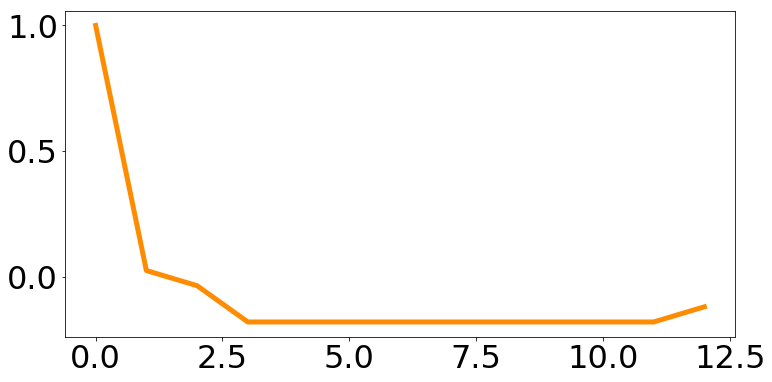

In [142]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
#spearmans_r=np.load("fixed_cascading_normal_lime_entire_dataset.npy", allow_pickle=True).item()
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['font.size']=32
plt.rcParams['lines.linewidth']=5

layers=["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]
layers.reverse()

ys=np.asarray([np.mean(spearmans_r[k]) for k in layers])
ys=np.concatenate([[1], smooth(ys,3)])
plt.plot(ys,c="darkorange")

([<matplotlib.axis.XTick at 0x7ece9bf79c50>,
 <a list of 13 Text xticklabel objects>)

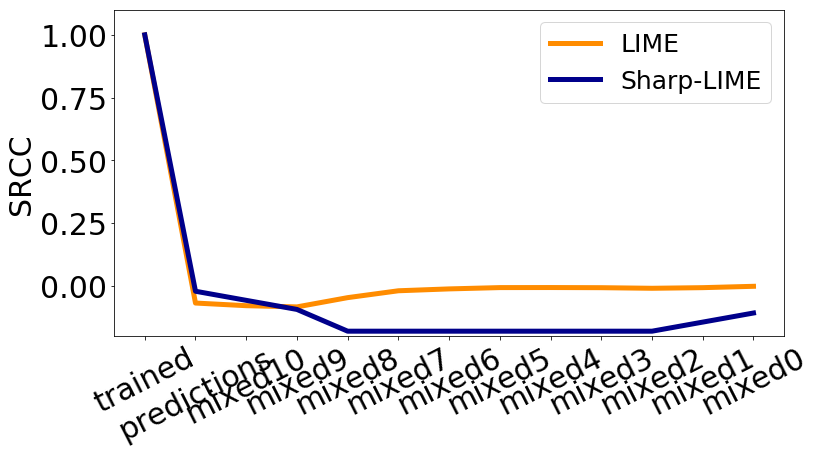

In [166]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
nspearmans_r=np.load("fixed_cascading_normal_lime_entire_dataset.npy", allow_pickle=True).item()
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['font.size']=30
plt.rcParams['lines.linewidth']=5

layers=["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]
layers.reverse()

ys=np.asarray([np.mean(nspearmans_r[k]) for k in layers])
ys=np.concatenate([[1], smooth(ys,5)])
plt.plot(ys,c="darkorange")

#spearmans_r=np.load("ugh.npy", allow_pickle=True).item()
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['font.size']=25
plt.rcParams['lines.linewidth']=5

layers=["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]
layers.reverse()

ys=np.asarray([np.mean(spearmans_r[k]) for k in layers])
ys=np.concatenate([[1], smooth(ys,5)])
plt.plot(ys,c="darkblue")

#plt.ylim(-0.20, 0.05)
plt.ylabel("SRCC")

"""spearmans_r=np.load("spearmans_r_sharplime_random.npy", allow_pickle=True).item()
#plt.rcParams['figure.figsize']=(20,8)
#plt.rcParams['font.size']=32
ys=np.asarray([np.mean(spearmans_r[k]) for k in ["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]])
plt.plot(smooth(ys,3),c="darkblue")
plt.xticks(np.arange(12), ["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"], rotation=20)"""
plt.ylim(-0.20, 1.1)
plt.ylabel("SRCC")
plt.legend(["LIME", "Sharp-LIME"])

list_=["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions","trained"]
list_.reverse()

plt.xticks(np.arange(13), list_, rotation=27)

In [119]:
smooth(ys,1)

array([ 0.01049918,  0.0010551 , -0.0228603 , -0.02688481, -0.01253221,
        0.02242577,  0.00386222, -0.02390104, -0.05284436, -0.04980999,
       -0.1144527 , -0.18054895])

In [ ]:
spearmans_r

In [44]:
np.save("normal_lime_cascading_quantitative.npy",spearmans_r)

Text(0, 0.5, 'SRCC')

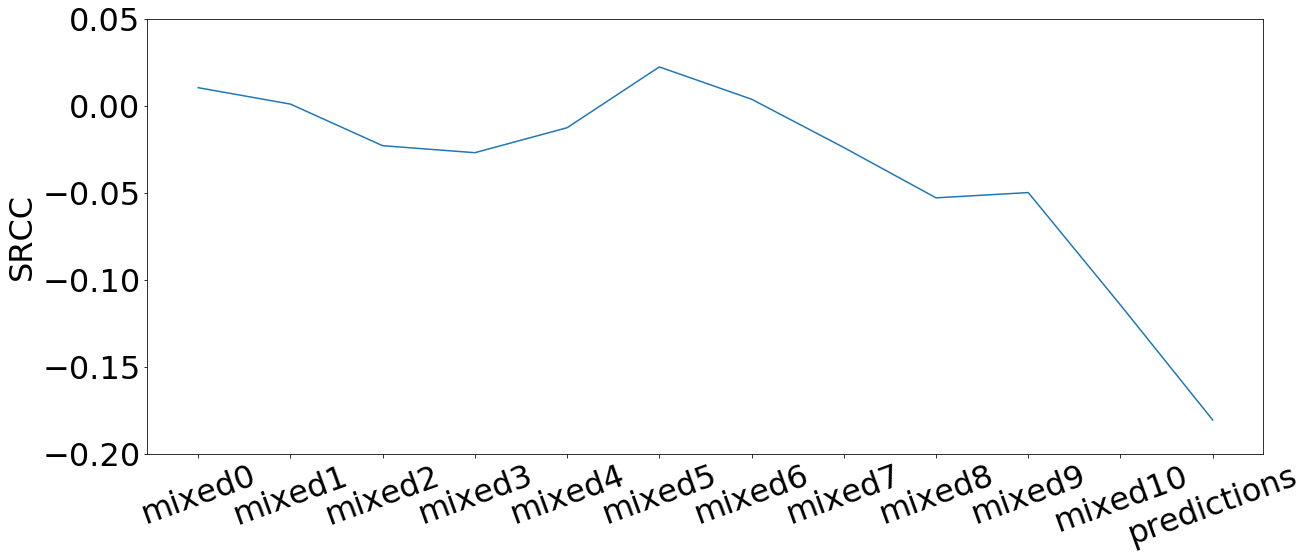

In [93]:

plt.rcParams['figure.figsize']=(20,8)
plt.rcParams['font.size']=32
plt.plot([np.mean(spearmans_r[k]) for k in ["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]])
plt.xticks(np.arange(12), ["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"], rotation=20)
plt.ylim(-0.20, 0.05)
plt.ylabel("SRCC")